In [ ]:
# This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import this

In [2]:
import os
import joblib

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

import optuna
import category_encoders as ce
import optuna.visualization as vis

from pycaret.regression import *

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
raw_train = pd.read_csv('data/Data_Train.csv')
raw_test = pd.read_csv('data/Data_Test.csv')

In [4]:
print(raw_train.info())
raw_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB
None


,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
2902,Rejuvenate Yourself - Floral Patterns,Dreamland Publications,"Paperback,– 2017",4.4 out of 5 stars,67 customer reviews,Drawing and colouring is not just for children...,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",123.00
3402,Every Last Word,Tamara Ireland Stone,"Paperback,– 6 Jun 2017",5.0 out of 5 stars,1 customer review,A New York Times Best Seller\nIf you could rea...,Romance (Books),Romance,708.00
1108,The Love Song of Miss Queenie Hennessy Or the ...,Rachel Joyce,"Paperback,– 16 Jul 2015",5.0 out of 5 stars,3 customer reviews,"From the author of the 2 million+ copy, worldw...",Action & Adventure (Books),Action & Adventure,254.01


In [5]:
print(raw_test.info())
raw_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1560 non-null   object
 1   Author        1560 non-null   object
 2   Edition       1560 non-null   object
 3   Reviews       1560 non-null   object
 4   Ratings       1560 non-null   object
 5   Synopsis      1560 non-null   object
 6   Genre         1560 non-null   object
 7   BookCategory  1560 non-null   object
dtypes: object(8)
memory usage: 97.6+ KB
None


,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
881,Some Lie And Some Die: (A Wexford Case),Ruth Rendell,"Paperback,– 4 Feb 2010",5.0 out of 5 stars,1 customer review,The eighth book to feature the classic crime-s...,"Crime, Thriller & Mystery (Books)","Crime, Thriller & Mystery"
1504,Batman: Heart of Hush,Paul Dini,"Paperback,– 16 Mar 2010",2.6 out of 5 stars,3 customer reviews,"The villain named Hush, created by comic super...",Comics,Comics & Mangas
1279,Galahad at Blandings (Everyman's Library P G W...,P.G. Wodehouse,"Hardcover,– 12 Feb 2009",5.0 out of 5 stars,2 customer reviews,"Lord Emsworth's prized pig, the Empress of Bla...",Contemporary Fiction (Books),Humour


In [10]:
title_price = defaultdict(set)

for i, row in tqdm(raw_train.iterrows(), total=raw_train.shape[0]):
    title, price = row['Title'], row['Price']
    title_price[title].add(price)

  0%|          | 0/6237 [00:00<?, ?it/s]

In [11]:
title_price

defaultdict(set,
            {"The Prisoner's Gold (The Hunters 3)": {220.0},
             'Guru Dutt: A Tragedy in Three Acts': {202.93},
             'Leviathan (Penguin Classics)': {299.0},
             'A Pocket Full of Rye (Miss Marple)': {180.0},
             'LIFE 70 Years of Extraordinary Photography': {965.62},
             'ChiRunning: A Revolutionary Approach to Effortless, Injury-Free Running': {900.0},
             'Death on the Nile (Poirot)': {224.0},
             'Yoga Your Home Practice Companion: A Complete Practice and Lifestyle Guide: Yoga Programmes, Meditation Exercises, and Nourishing Recipes (Sivananda Yoga Vedanta Centre)': {836.0},
             'Karmayogi: A Biography of E. Sreedharan': {130.0},
             'The Iron King (The Accursed Kings, Book 1)': {695.0,
              713.0,
              719.0},
             'Battle for Sanskrit: Is Sanskrit Political or Sacred? Oppressive or Liberating? Dead or Alive?': {373.0},
             'Blockchain Revolution: Ho

In [37]:
raw_train[['Title', 'Price']].set_index('Title').T.to_dict()

<ipython-input-37-ea8e2f849a68>:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  raw_train[['Title', 'Price']].set_index('Title').T.to_dict()


{"The Prisoner's Gold (The Hunters 3)": {'Price': 220.0},
 'Guru Dutt: A Tragedy in Three Acts': {'Price': 202.93},
 'Leviathan (Penguin Classics)': {'Price': 299.0},
 'A Pocket Full of Rye (Miss Marple)': {'Price': 180.0},
 'LIFE 70 Years of Extraordinary Photography': {'Price': 965.62},
 'ChiRunning: A Revolutionary Approach to Effortless, Injury-Free Running': {'Price': 900.0},
 'Death on the Nile (Poirot)': {'Price': 224.0},
 'Yoga Your Home Practice Companion: A Complete Practice and Lifestyle Guide: Yoga Programmes, Meditation Exercises, and Nourishing Recipes (Sivananda Yoga Vedanta Centre)': {'Price': 836.0},
 'Karmayogi: A Biography of E. Sreedharan': {'Price': 130.0},
 'The Iron King (The Accursed Kings, Book 1)': {'Price': 719.0},
 'Battle for Sanskrit: Is Sanskrit Political or Sacred? Oppressive or Liberating? Dead or Alive?': {'Price': 373.0},
 'Blockchain Revolution: How the Technology Behind Bitcoin and Other Cryptocurrencies is Changing the World': {'Price': 309.0},
 'T

In [ ]:
# This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import this

In [62]:
mask = raw_train.duplicated(['Title', 'Edition'], keep=False)
raw_train[mask].sort_values(by='Title')[:10]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
3329,10 Minutes a Day Vocabulary Ages 7-11 Key Stag...,Carol Vorderman,"Paperback,– 1 Jun 2015",4.5 out of 5 stars,4 customer reviews,Spend just 10 minutes a day learning and maste...,Action & Adventure (Books),Action & Adventure,238.00
4411,10 Minutes a Day Vocabulary Ages 7-11 Key Stag...,Carol Vorderman,"Paperback,– 1 Jun 2015",4.5 out of 5 stars,4 customer reviews,Spend just 10 minutes a day learning and maste...,Action & Adventure (Books),Action & Adventure,261.00
1520,100 Bullets Book One,Brian Azzarello,"Paperback,– 4 Nov 2014",4.0 out of 5 stars,3 customer reviews,The best-selling graphic novels series 100 Bul...,Humour (Books),Comics & Mangas,1199.00
4861,100 Bullets Book One,Brian Azzarello,"Paperback,– 4 Nov 2014",4.0 out of 5 stars,3 customer reviews,The best-selling graphic novels series 100 Bul...,Humour (Books),Humour,1199.00
1371,100 Deadly Skills,Clint Emerson,"Paperback,– 28 Oct 2016",3.0 out of 5 stars,2 customer reviews,From national bestselling author and retired N...,Healthy Living & Wellness (Books),Sports,569.00
5120,100 Deadly Skills,Clint Emerson,"Paperback,– 28 Oct 2016",3.0 out of 5 stars,2 customer reviews,From national bestselling author and retired N...,Healthy Living & Wellness (Books),Politics,423.45
1654,112 Meditations for Self Realization: Vigyan B...,Ranjit Chaudhri,"Paperback,– 2014",4.2 out of 5 stars,26 customer reviews,The Vigyan Bhairava Tantra is one of yoga's mo...,Action & Adventure (Books),Action & Adventure,199.00
2613,112 Meditations for Self Realization: Vigyan B...,Ranjit Chaudhri,"Paperback,– 2014",4.1 out of 5 stars,25 customer reviews,The Vigyan Bhairava Tantra is one of yoga's mo...,Action & Adventure (Books),Action & Adventure,199.00
3800,1984,George Orwell,"Paperback,– 2014",4.5 out of 5 stars,867 customer reviews,Regarded as a great instance of twentieth cent...,Action & Adventure (Books),Action & Adventure,94.00
1850,1984,George Orwell,"Paperback,– 2014",4.5 out of 5 stars,862 customer reviews,Regarded as a great instance of twentieth cent...,Action & Adventure (Books),Action & Adventure,94.00


In [6]:
combine = raw_train.append(raw_test).reset_index(drop=True)
combine.shape

(7797, 9)

In [7]:
combine['no_of_reviews'] = combine['Ratings'].str.split().str[0].replace({',': ''}, regex=True).astype(int)
combine['avg_rating'] = combine['Reviews'].str.split().str[0].astype(float)

combine = combine.drop(['Reviews', 'Ratings'], axis=1)

In [8]:
combine['book_type'] = combine['Edition'].str.split(',').str[0]

In [9]:
book_types = ['(Kannada)', '(German)', 'Perfect Paperback', '(French)', '(Chinese)', '(Spanish)']

mask = combine['book_type'].isin(book_types)
combine.loc[mask, 'book_type'] = 'Paperback'

In [10]:
book_types = ['Paperback', 'Hardcover', "Mass Market Paperback", 'Sheet music', 'Flexibound']

mask = ~combine['book_type'].isin(book_types)
combine.loc[mask, 'book_type'] = 'other'

In [11]:
combine['book_type'].value_counts()

Paperback                6464
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
other                      26
Flexibound                 19
Name: book_type, dtype: int64

In [12]:
combine = combine.drop('Genre', axis=1)

In [13]:
famous_authors = combine['Author'].value_counts()[:20].index.tolist()
mask = ~combine['Author'].isin(famous_authors)

combine.loc[mask, 'Author'] = 'Other'

In [14]:
combine['year'] = combine['Edition'].str.extract(pat='([0-9]{4})').astype(float)

In [15]:
combine['year'].fillna(combine['year'].median(), inplace=True)

In [16]:
combine.drop(['Title', 'Synopsis', 'Edition'], axis=1, inplace=True)

In [117]:
combine['Title'].nunique()

KeyError: 'Title'

In [63]:
mask = (combine.duplicated('Title', keep=False)) & (combine['Price'].isna())
combine[mask]

,Title,Author,Edition,Synopsis,BookCategory,Price,no_of_reviews,avg_rating,tmp
6237,The Complete Sherlock Holmes: 2 Boxes sets,Other,"Mass Market Paperback,– 1 Oct 1986",A collection of entire body of work of the She...,"Crime, Thriller & Mystery",NaN,960,4.4,Mass Market Paperback
6246,Doing Justice: A Prosecutor’s Thoughts on Crim...,Other,"Paperback,– 19 Mar 2019",A Guardian Pick for 2019\nThe People vs. Putin...,Action & Adventure,NaN,6,4.4,Paperback
6247,Courtney's War,Wilbur Smith,"Paperback,– 6 Sep 2018",The brand-new Courtney Series novel and the mu...,Romance,NaN,12,3.3,Paperback
6249,Alice's Adventures in Wonderland and Through t...,Other,"Paperback,– 29 Apr 2003","Original, experimental, and unparalleled in th...",Action & Adventure,NaN,39,4.2,Paperback
6261,Cricket's Strangest Matches: Extraordinary but...,Other,"Paperback,– 1 Jul 2016",Cricket’s Strangest Tales is a fascinating col...,Humour,NaN,2,4.5,Paperback
...,...,...,...,...,...,...,...,...,...
7782,The Messy Middle,Other,"Paperback,– 5 Nov 2018",Silicon Valley is full of start-up success sto...,"Computing, Internet & Digital Media",NaN,6,4.2,Paperback
7787,A Song of Ice and Fire - A Game of Thrones: Th...,Other,"Paperback,– 5 Jan 2016",HBO’s hit series A Game of Thrones is based on...,Action & Adventure,NaN,296,4.5,Paperback
7791,Guardians of Being,Other,"Paperback,– 15 Nov 2011","A noted author and the creator of the ""Mutts"" ...",Humour,NaN,6,3.6,Paperback
7792,100 Things Every Designer Needs to Know About ...,Other,"Paperback,– 14 Apr 2011",We design to elicit responses from people. We ...,"Computing, Internet & Digital Media",NaN,4,5.0,Paperback


In [65]:
mask = combine['Title'] == 'Courtney\'s War'
combine.loc[mask]

,Title,Author,Edition,Synopsis,BookCategory,Price,no_of_reviews,avg_rating,tmp
6247,Courtney's War,Wilbur Smith,"Paperback,– 6 Sep 2018",The brand-new Courtney Series novel and the mu...,Romance,NaN,12,3.3,Paperback
7107,Courtney's War,Wilbur Smith,"Paperback,– 6 Sep 2018",The brand-new Courtney Series novel and the mu...,Action & Adventure,NaN,13,3.4,Paperback


In [28]:
mask = combine['year'].isna()
combine.loc[mask]

,Title,Author,Edition,Synopsis,Genre,BookCategory,Price,no_of_reviews,avg_rating,tmp,year
169,Long Walk to Freedom: Illustrated Children's e...,Nelson Mandela,"Paperback,– Abridged, Import",Long Walk to Freedom by Nelson Mandela is the ...,Action & Adventure (Books),Action & Adventure,418.0,2,5.0,Paperback,NaN
235,Alfred's Basic Adult All-in-One Course: Lesson...,Willard A. Palmer,"Plastic Comb,– DVD, NTSC",Alfred's Basic Adult All-in-One Course is a gr...,Music Books,"Arts, Film & Photography",1453.0,6,3.9,Plastic Comb,NaN
582,Fundamentals of Drawing Portraits: A Practical...,Barrington Barber,"Paperback,– Illustrated, Import",This book is essential for everyone who wants ...,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",415.0,7,4.0,Paperback,NaN
972,"Cartooning, The Professional Step-by-Step Guid...","Ivan Hissey, Curtis Tappenden","Paperback,– Illustrated, Import",A comprehensive and practical guide to drawing...,"Handicrafts, Decorative Arts & Crafts (Books)",Comics & Mangas,445.0,1,3.0,Paperback,NaN
1233,Amma Tell Me About Raksha Bandhan!,Bhakti Mathur,"Paperback,– Large Print, Import",A promise to love and to protect\nIs sealed by...,Action & Adventure (Books),Action & Adventure,277.0,1,5.0,Paperback,NaN
1558,Figure it out for Yourself,James Hadley Chase,"Hardcover,– Import, Facsimile",Serena Marshland was the fourth richest woman ...,"Crime, Thriller & Mystery (Books)","Crime, Thriller & Mystery",100.0,1,5.0,Hardcover,NaN
1605,"An Introduction to Linguistics: Language, Gram...",Syal,"Paperback,– Abridged, Audiobook, Box set","This compact and engagingly elegant text, now ...",Engineering,"Language, Linguistics & Writing",399.0,29,4.1,Paperback,NaN
1631,Swimming: Swimming Made Easy: Beginner and Exp...,Ace McCloud,"Paperback,– Large Print, Import",Are you tired of being a weak swimmer? Do less...,"Swimming, Snorkelling & Diving (Books)",Sports,709.0,1,4.0,Paperback,NaN
1643,The Merchant of Venice (Text with Paraphrase) ...,William Shakespeare,"Paperback,– Student Edition, Special Edition",Introduce the students to William Shakespeare’...,Theater,"Arts, Film & Photography",220.0,58,3.9,Paperback,NaN
1769,The Human Face of Big Data,Rick Smolan,"Hardcover,– Abridged, Audiobook, Box set",The images and stories captured in The Human F...,Computer Science Books,"Computing, Internet & Digital Media",2248.0,1,5.0,Hardcover,NaN


In [29]:
combine.groupby('tmp').mean()

,Price,no_of_reviews,avg_rating
tmp,,,
(Chinese),NaN,1.000000,5.000000
(French),657.000000,1.000000,5.000000
(German),557.000000,2.000000,5.000000
(Kannada),93.000000,53.000000,4.200000
(Spanish),295.000000,4.000000,5.000000
Board book,452.690000,8.000000,4.500000
Cards,721.983750,4.444444,4.677778
Flexibound,713.344000,37.631579,4.447368
Hardcover,983.294168,32.876894,4.380208


In [21]:
combine.sample(5)

,Title,Author,Edition,Synopsis,BookCategory,Price,no_of_reviews,avg_rating,tmp,year
6819,English for Everyone Course Book - Level 1 Beg...,DK,"Flexibound,– 4 Oct 2016",English for Everyone is an exciting and compre...,"Language, Linguistics & Writing",NaN,3,4.4,Flexibound,2016
6897,AB de Villiers - The Autobiography,Other,"Paperback,– 6 Sep 2016",The Autobiography of One of the World's Finest...,"Biographies, Diaries & True Accounts",NaN,234,4.6,Paperback,2016
1364,Chemistry (Pearson International Baccalaureate...,Other,"Paperback,– Student Edition, 30 May 2014",This is a completely revised edition of the ma...,"Language, Linguistics & Writing",5064.0,2,4.6,Paperback,2014
895,Python Machine Learning By Example,Other,"Paperback,– Import, 31 May 2017",Take tiny steps to enter the big world of data...,"Computing, Internet & Digital Media",2798.0,26,4.3,Paperback,2017
1674,Night Probe! (Dirk Pitt),Clive Cussler,"Paperback,– 1 Jan 1988",A SUNDAY TIMES BESTSELLER\n'Cussler is hard to...,Action & Adventure,275.0,1,4.0,Paperback,1988


In [17]:
print(combine.info())
combine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Author         7797 non-null   object 
 1   BookCategory   7797 non-null   object 
 2   Price          6237 non-null   float64
 3   no_of_reviews  7797 non-null   int64  
 4   avg_rating     7797 non-null   float64
 5   book_type      7797 non-null   object 
 6   year           7797 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 426.5+ KB
None


,Author,BookCategory,Price,no_of_reviews,avg_rating,book_type,year
0,Other,Action & Adventure,220.00,8,4.0,Paperback,2016.0
1,Other,"Biographies, Diaries & True Accounts",202.93,14,3.9,Paperback,2012.0
2,Other,Humour,299.00,6,4.8,Paperback,1982.0
3,Agatha Christie,"Crime, Thriller & Mystery",180.00,13,4.1,Paperback,2017.0
4,Other,"Arts, Film & Photography",965.62,1,5.0,Hardcover,2006.0


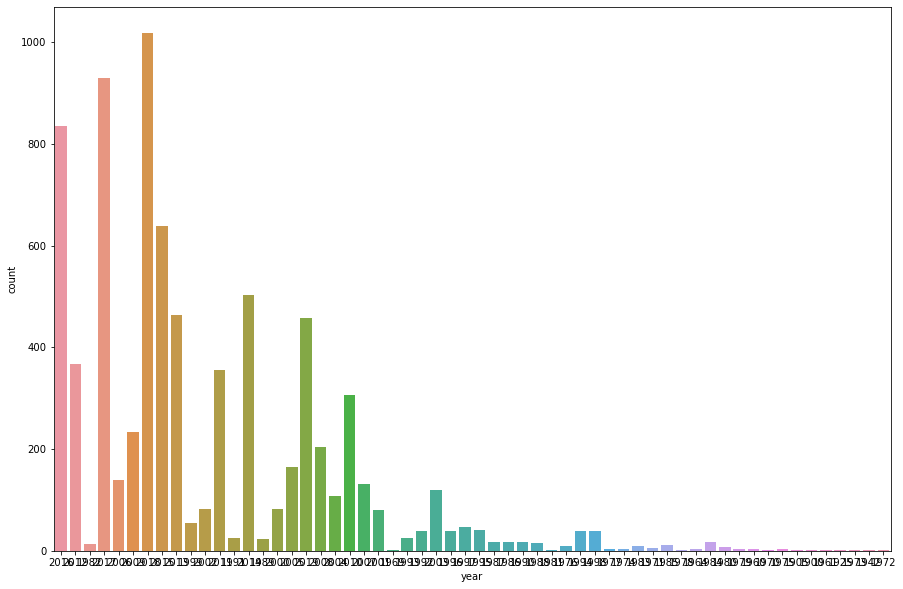

In [29]:
plt.figure(figsize=(15, 10))
sns.countplot(data=combine, x='year')
plt.show()

<AxesSubplot:>

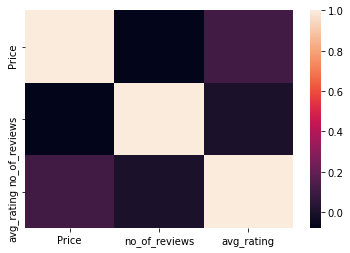

In [30]:
sns.heatmap(combine.corr())

In [18]:
mask = combine['Price'].isna()

train = combine.loc[~mask]
test = combine.loc[mask].drop('Price', axis=1)

print(train.shape, test.shape)

(6237, 7) (1560, 6)


In [19]:
cat_cols = train.select_dtypes(include='object').columns.tolist()

for c in cat_cols:
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    test[c] = le.transform(test[c])

<AxesSubplot:>

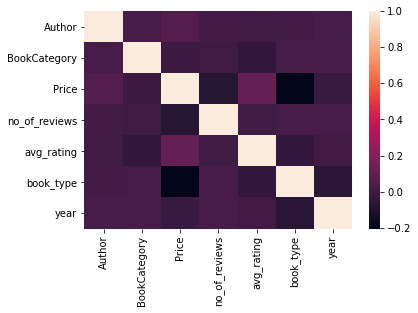

In [20]:
sns.heatmap(train.corr())

In [123]:
X = train.drop('Price', axis=1)
y = train['Price']

In [31]:
data_setup = setup(
    data=train,
    target='Price',
    train_size=0.75,
    transform_target=True,
    transform_target_method='box-cox',
    fold_shuffle=True,
)

,Description,Value
0,session_id,6312
1,Target,Price
2,Original Data,"(6237, 7)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4677, 21)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [32]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,265.0451,357954.6927,589.3592,0.1540,0.6170,0.5213,1.4560
lightgbm,Light Gradient Boosting Machine,266.7723,360585.1077,591.6777,0.1472,0.6244,0.5307,0.8800
gbr,Gradient Boosting Regressor,265.7309,364248.7424,594.8076,0.1384,0.6212,0.5259,0.1490
xgboost,Extreme Gradient Boosting,277.7742,368442.1781,599.3843,0.1221,0.6501,0.5616,0.8650
rf,Random Forest Regressor,278.9758,372165.1288,602.0567,0.1134,0.6555,0.5597,0.5690
lar,Least Angle Regression,278.2070,375804.4974,605.5377,0.1038,0.6742,0.5848,0.0200
lr,Linear Regression,276.7538,379825.6984,608.3685,0.0965,0.6621,0.5726,0.0290
ridge,Ridge Regression,276.7184,379917.7438,608.4290,0.0963,0.6621,0.5724,0.0180
br,Bayesian Ridge,276.5887,380592.7620,608.9228,0.0950,0.6620,0.5717,0.0180
huber,Huber Regressor,276.6886,382098.8375,609.9759,0.0924,0.6646,0.5843,0.1210


In [33]:
final_model = finalize_model(best_model)

In [34]:
preds = predict_model(final_model, data=test)

In [36]:
preds

,Author,BookCategory,no_of_reviews,avg_rating,book_type,year,Label
6237,15,5,960,4.4,2,1986.0,300.929159
6238,15,4,1,5.0,3,2018.0,808.120217
6239,5,9,4,5.0,3,2011.0,329.406807
6240,15,4,11,4.1,3,2016.0,633.879851
6241,15,7,9,4.4,3,2011.0,330.620455
...,...,...,...,...,...,...,...
7792,15,4,4,5.0,3,2011.0,587.089714
7793,15,2,13,3.6,3,2013.0,260.529900
7794,15,6,5,4.0,3,2011.0,384.673817
7795,15,2,3,3.5,3,2009.0,252.092580


In [37]:
sub = pd.DataFrame({ 'Price': preds['Label'] })
print(sub.shape)
sub.head()

(1560, 1)


,Price
6237,300.929159
6238,808.120217
6239,329.406807
6240,633.879851
6241,330.620455


In [39]:
sub.to_csv('submissions/pycaret_1.csv', index=False)

In [124]:
rf = RandomForestRegressor()

In [95]:
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error')

In [135]:
print(np.sqrt(np.abs(scores)))
np.sqrt(np.abs(scores)).mean()

[645.49930097 695.32796718 689.65237437 681.29581873 690.1254639 ]


680.3801850275214

In [125]:
rf.fit(X, y)

RandomForestRegressor()

In [126]:
preds = rf.predict(test)

In [127]:
print(preds)

[338.99       685.3441732  397.18533333 ... 476.6223     428.9453
 870.68695333]


In [131]:
sub = pd.DataFrame({ 'Price': preds })
print(sub.shape)
sub.head()

(1560, 1)


,Price
0,338.990000
1,685.344173
2,397.185333
3,841.416700
4,352.193700


In [132]:
sub.to_csv('submissions/rf_firstsub.csv', index=False)

In [133]:
sub['Price'].describe()

count    1560.000000
mean      600.591260
std       411.557265
min        68.624230
25%       334.268844
50%       472.461750
75%       720.080390
max      3946.409857
Name: Price, dtype: float64